In [1]:
!pip install yfinance numpy pandas scikit-learn tensorflow hypergraph-network


ERROR: Could not find a version that satisfies the requirement hypergraph-network (from versions: none)
ERROR: No matching distribution found for hypergraph-network


[*********************100%%**********************]  6 of 6 completed


Epoch 1/10, Loss: 51171.421875
Epoch 2/10, Loss: 48085.87109375
Epoch 3/10, Loss: 45163.26953125
Epoch 4/10, Loss: 42415.0234375
Epoch 5/10, Loss: 39824.890625
Epoch 6/10, Loss: 37412.6796875
Epoch 7/10, Loss: 35155.55859375
Epoch 8/10, Loss: 33021.13671875
Epoch 9/10, Loss: 30998.166015625
Epoch 10/10, Loss: 29094.515625
Test Loss (RMSE): 165.1657257080078


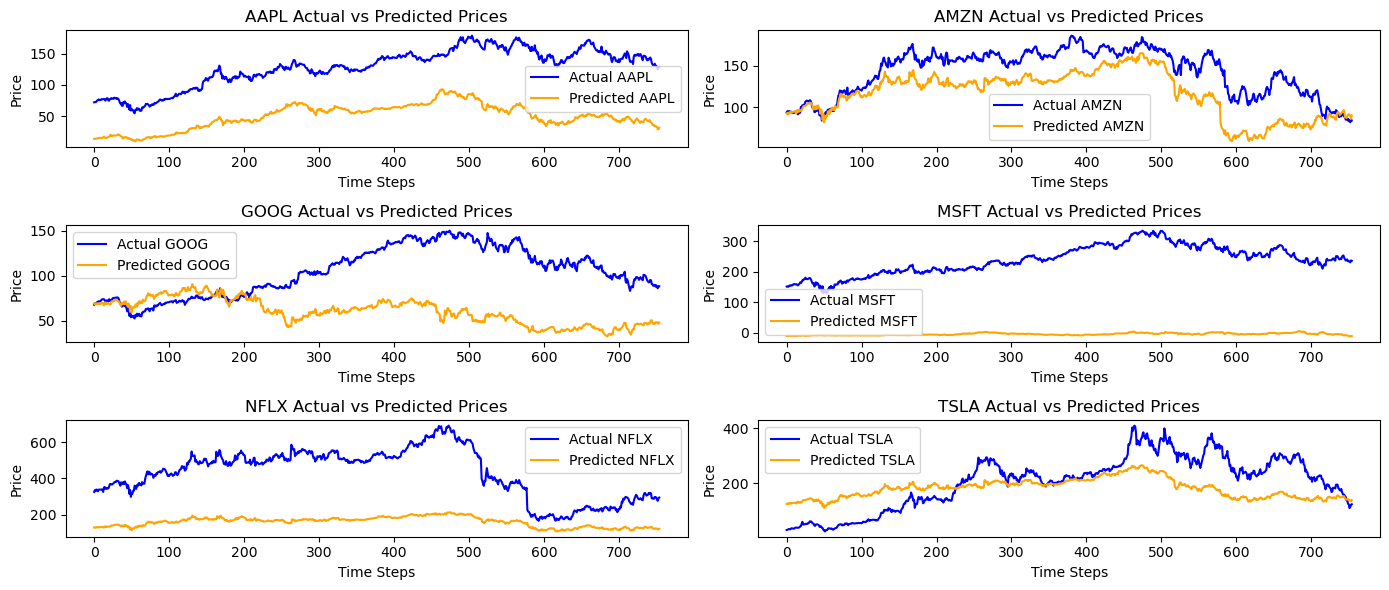

In [7]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

# Set seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

# Function to fetch stock data from yfinance for multiple tickers
def fetch_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.fillna(method='ffill')  # Handle missing data
    return data

# Build a simplified model for multiple tickers
class SimpleModel(tf.keras.Model):
    def __init__(self, hidden_units=64, output_units=6):  # Adjust output_units to 6 for six tickers
        super(SimpleModel, self).__init__()
        self.hidden_units = hidden_units

        # Dense layers
        self.dense1 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense_out = tf.keras.layers.Dense(output_units, activation='linear')  # Predicting future stock prices

    def call(self, features):
        # First dense layer
        x = self.dense1(features)  # Shape: [batch_size, hidden_units]

        # Second dense layer
        x = self.dense2(x)

        # Final output layer
        out = self.dense_out(x)  # Output shape: [batch_size, output_units]
        return out

# Training function with RMSE printing
def train_model(model, stock_data, epochs=50, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    mse_loss = tf.keras.losses.MeanSquaredError()

    # Prepare input and target data
    current_features = stock_data[:-1].values  # Features: previous day prices
    next_day_prices = stock_data[1:].values  # Target: next day's prices
    
    # Convert to tensors
    current_features = tf.convert_to_tensor(current_features, dtype=tf.float32)
    next_day_prices = tf.convert_to_tensor(next_day_prices, dtype=tf.float32)

    # Training loop
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Forward pass through the model
            predictions = model(current_features)

            # Calculate the loss (MSE between predicted and actual future prices)
            loss = mse_loss(next_day_prices, predictions)

        # Compute gradients and apply updates
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}")

# Testing function with RMSE printing and visualization
def test_model(model, stock_data):
    current_features = stock_data[:-1].values  # Shape: [time_steps, 6]
    next_day_prices = stock_data[1:].values  # Actual future prices

    # Convert to tensors
    current_features = tf.convert_to_tensor(current_features, dtype=tf.float32)
    next_day_prices = tf.convert_to_tensor(next_day_prices, dtype=tf.float32)

    predictions = model(current_features)
    
    mse_loss = tf.keras.losses.MeanSquaredError()
    test_mse = mse_loss(next_day_prices, predictions)
    
    # Compute RMSE
    test_rmse = np.sqrt(test_mse.numpy())  # Correct RMSE calculation
    print(f"Test Loss (RMSE): {test_rmse}")

    # Visualize actual vs predicted prices for both tickers
    visualize_predictions(stock_data, next_day_prices, predictions.numpy())

# Visualization of predictions vs actual stock prices
def visualize_predictions(stock_data, actual_prices, predicted_prices):
    tickers = stock_data.columns
    time_steps = np.arange(len(actual_prices))
    
    plt.figure(figsize=(14, 6))

    for i, ticker in enumerate(tickers):
        plt.subplot(3, 2, i + 1)  # Adjust for 6 tickers (3 rows, 2 columns)
        plt.plot(time_steps, actual_prices[:, i], label=f'Actual {ticker}', color='blue')
        plt.plot(time_steps, predicted_prices[:, i], label=f'Predicted {ticker}', color='orange')
        plt.title(f'{ticker} Actual vs Predicted Prices')
        plt.xlabel('Time Steps')
        plt.ylabel('Price')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Define tickers and date range (AAPL, GOOG, MSFT, AMZN, TSLA, NFLX)
    tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'TSLA', 'NFLX']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data from yfinance
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Define and compile the model
    model = SimpleModel(output_units=len(tickers))  # Adjust output to match the number of tickers

    # Train the model
    train_model(model, stock_data, epochs=10, learning_rate=0.001)

    # Test the model and visualize results
    test_model(model, stock_data)

if __name__ == "__main__":
    main()


[*********************100%%**********************]  2 of 2 completed


Epoch 1/10, Loss: 919.9198608398438
Epoch 2/10, Loss: 626.8899536132812
Epoch 3/10, Loss: 396.60247802734375
Epoch 4/10, Loss: 230.4633331298828
Epoch 5/10, Loss: 122.9390869140625
Epoch 6/10, Loss: 64.13268280029297
Epoch 7/10, Loss: 40.87773132324219
Epoch 8/10, Loss: 40.024131774902344
Epoch 9/10, Loss: 50.69737243652344
Epoch 10/10, Loss: 64.3213119506836
Test Loss (RMSE): 8.664632797241211


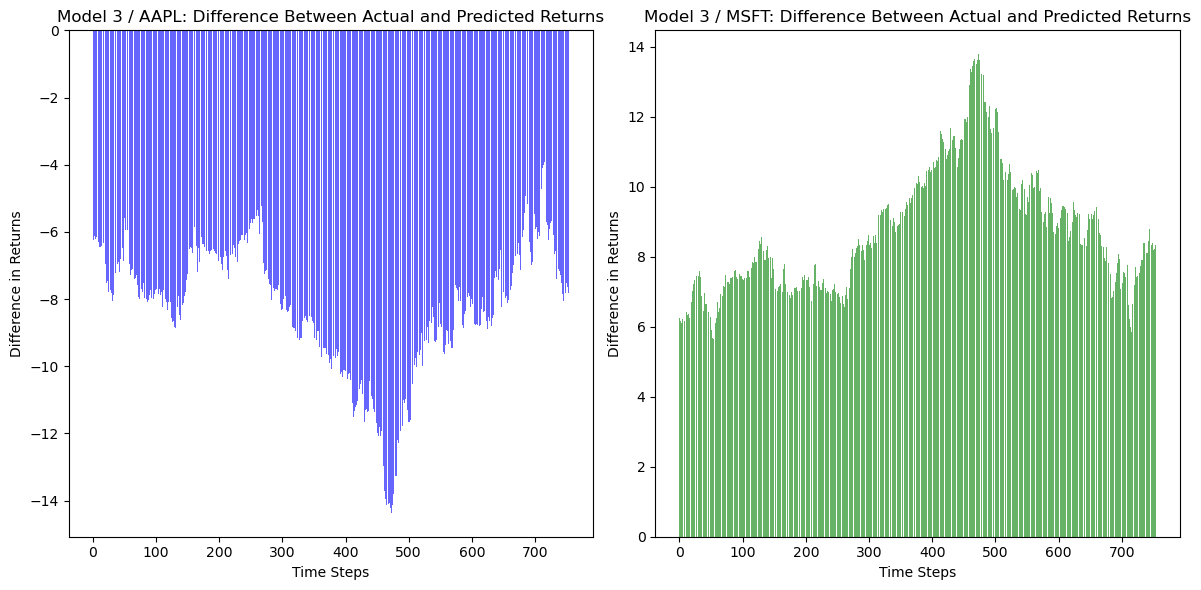

In [11]:
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

# Set seeds for reproducibility
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

# Function to fetch stock data from yfinance for multiple tickers
def fetch_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    data = data.fillna(method='ffill')  # Handle missing data
    return data

# Build a simplified model for multiple tickers (AAPL and MSFT)
class SimpleModel(tf.keras.Model):
    def __init__(self, hidden_units=64):
        super(SimpleModel, self).__init__()
        self.hidden_units = hidden_units

        # Dense layers
        self.dense1 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_units, activation='relu')
        self.dense_out = tf.keras.layers.Dense(2, activation='linear')  # Output layer (predicting returns for 2 tickers)

    def call(self, features):
        # First dense layer
        x = self.dense1(features)  # Shape: [batch_size, hidden_units]

        # Second dense layer
        x = self.dense2(x)

        # Final output layer
        out = self.dense_out(x)  # Output shape: [batch_size, 2] for AAPL and MSFT
        return out

# Training function with RMSE printing
def train_model(model, stock_data, epochs=50, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    mse_loss = tf.keras.losses.MeanSquaredError()

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Get current features (previous day prices) and next day returns as targets
            current_features = stock_data[:-1].values  # Shape: [time_steps, 2] for two tickers
            next_day_returns = (stock_data[1:].values - stock_data[:-1].values) / stock_data[:-1].values  # Next day returns
            
            # Forward pass through the model
            predictions = model(current_features)

            # Calculate the loss (MSE between predicted and actual returns for both tickers)
            loss = mse_loss(next_day_returns, predictions)

        # Compute gradients and apply updates
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}")

# Testing function with RMSE printing and visualization return
def test_model(model, stock_data):
    current_features = stock_data[:-1].values  # Shape: [time_steps, 2]
    next_day_returns = (stock_data[1:].values - stock_data[:-1].values) / stock_data[:-1].values
    predictions = model(current_features)
    
    mse_loss = tf.keras.losses.MeanSquaredError()
    test_mse = mse_loss(next_day_returns, predictions)
    
    # Compute RMSE
    test_rmse = tf.sqrt(test_mse)
    
    print(f"Test Loss (RMSE): {test_rmse.numpy()}")

    # Return actual and predicted values for visualization
    return next_day_returns, predictions

# Visualization function with bar plot
def visualize_results(actual_returns, predicted_returns):
    # Calculate the difference between actual and predicted returns
    differences_aapl = actual_returns[:, 0] - predicted_returns[:, 0]
    differences_msft = actual_returns[:, 1] - predicted_returns[:, 1]

    # Create bar plot to show the differences
    plt.figure(figsize=(12, 6))

    # Bar plot for AAPL
    plt.subplot(1, 2, 1)
    plt.bar(range(len(differences_aapl)), differences_aapl, color='blue', alpha=0.6)
    plt.title('Model 3 / AAPL: Difference Between Actual and Predicted Returns')
    plt.xlabel('Time Steps')
    plt.ylabel('Difference in Returns')

    # Bar plot for MSFT
    plt.subplot(1, 2, 2)
    plt.bar(range(len(differences_msft)), differences_msft, color='green', alpha=0.6)
    plt.title('Model 3 / MSFT: Difference Between Actual and Predicted Returns')
    plt.xlabel('Time Steps')
    plt.ylabel('Difference in Returns')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Define tickers and date range (AAPL and MSFT in this case)
    tickers = ['AAPL', 'MSFT']
    start_date = '2020-01-01'
    end_date = '2023-01-01'

    # Fetch stock data from yfinance
    stock_data = fetch_stock_data(tickers, start_date, end_date)

    # Define and compile the model
    model = SimpleModel()

    # Train the model
    train_model(model, stock_data, epochs=10, learning_rate=0.001)

    # Test the model and get actual and predicted returns
    actual_returns, predicted_returns = test_model(model, stock_data)

    # Visualize the results using bar plot
    visualize_results(actual_returns, predicted_returns)

# Run the main function
if __name__ == "__main__":
    main()
